In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import timedelta
import os
import pickle
from timeit import default_timer as timer
from datetime import timedelta
from IPython.display import clear_output

import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
seed = 1

os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。

random.seed(seed)
np.random.seed(seed)

# env.seed(seed)  这个等创建了环境之后再设置

torch.manual_seed(seed)            # 为CPU设置随机种子
torch.cuda.manual_seed(seed)       # 为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed)   # 为所有GPU设置随机种子

# Replay memory

In [3]:
class ExperienceReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        
    def add(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        sub_buffer = random.sample(self.memory, batch_size)
        return sub_buffer
    
    def __len__(self):
        return len(self.memory)   

# Network

In [4]:
class DQNMLP(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super(DQNMLP, self).__init__()
        
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        
        self.fc1 = nn.Linear(self.obs_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, self.action_dim)
        
    def forward(self, obs):   # obs is set to be tensor
        x = F.relu(self.fc1(obs))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x       

# Config

In [5]:
class Config(object):
    def __init__(self):
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        #epsilon variables    espislon-greedy exploration
        self.epsilon_start = 0.1   # 1
        self.epsilon_final = 0.1   # 0.01
        self.epsilon_decay = 30000
        '''
        epsilon随着traning step增加递减, 探索得越来越少，
        但是这不是对于SARSA来说才需要的吗，对于Q-learning，behavior policy可以保持一定的探索程度
        留个疑问，之后看看其他大佬的代码是怎么处理这一部分的
        目前我的想法是：因为在DQN里target_model其实是拷贝model的参数，所以model的epsilon是需要逐渐变小的（为了达到最优）
        如果不用model来收集数据，而是用另一个策略（比如随机的策略），那么model可以不用考虑探索（epsilon=0）
        但是用完全随机的策略而不是用逐渐变好的策略（假设训练是有效的）作为behavior policy的缺点在于
        对于好的action不能更多的采样来估计准它的value, 而且又要额外多用一个策略，不如就用model来收集数据
        '''
        self.epsilon_by_step = lambda step: self.epsilon_final + (self.epsilon_start - self.epsilon_final) * np.exp(-1. * step / self.epsilon_decay)
        
        # learning control variables
        self.gamma = 0.99
        self.lr = 1e-4
        self.max_steps = int(1e6)
        self.batch_size = 32
        self.target_net_update_freq = 1000
        self.training_env_seed = 123
        
        
        #memory
        self.experience_replay_size = int(1e5)
        self.learn_start = 1000      

# Agent

In [48]:
class DQNAgent(object):
    def __init__(self, env_name=None, network=None, eval_mode=False, config=None):
        '''
        agent里的self.env用来训练
        评估的环境在外面重新创建一个： env = gym.make(self.env_name)
        '''
        self.env_name = env_name
        self.env = gym.make(env_name)
        self.env.seed(config.training_env_seed)
        
        self.obs_dim = self.env.observation_space.shape[0]   # 根据环境来设置
        self.action_dim = self.env.action_space.n
        
        self.eval_mode = eval_mode
        
        self.gamma = config.gamma
        self.lr = config.lr
        self.target_net_update_freq = config.target_net_update_freq
        self.experience_replay_size = config.experience_replay_size
        self.learn_start = config.learn_start
        self.batch_size = config.batch_size
        
        self.memory = ExperienceReplayMemory(self.experience_replay_size)
        
        self.network = network
        self.device = config.device
        
        self.model = self.network(self.obs_dim, self.action_dim)
        self.target_model = self.network(self.obs_dim, self.action_dim)
        self.target_model.load_state_dict(self.model.state_dict())

        # move to correct device
        self.model = self.model.to(self.device)
        self.target_model.to(self.device)
                
        # train和eval模式的差别主要是Batch Normalization和Dropout的使用差别
        if self.eval_mode:
            self.model.eval()
            self.target_model.eval()
        else:
            self.model.train()
            self.target_model.train()
            
        self.optimizer = optim.Adam(self.model.parameters(), self.lr)
        # 加了学习率衰减反而不好
        # self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=100000, gamma = 0.1)
        # self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma = 0.99)
        self.loss = nn.SmoothL1Loss(reduction='none')
        
        self.update_count = 0
        self.losses = []
        self.rewards = []
        self.episode_length = []
        
        
    def train(self, step=0):
        if self.eval_mode:
            return None
        
        if step < self.learn_start:
            return None
        
        transitions = self.memory.sample(self.batch_size)
        
        obses_t, actions, rewards, obses_tp1, dones = zip(*transitions)
        
        obses_t = torch.tensor(obses_t, dtype=torch.float, device=self.device)
        actions = torch.tensor(actions, dtype=torch.long, device=self.device).squeeze().view(-1, 1)
        rewards = torch.tensor(rewards, dtype=torch.float, device=self.device).squeeze().view(-1, 1)
        obses_tp1 = torch.tensor(obses_tp1, dtype=torch.float, device=self.device)
        dones = torch.tensor(dones, dtype=torch.int32, device=self.device).squeeze().view(-1, 1)  
        
        
        # compute loss
        chose_q_vals = self.model(obses_t).gather(dim=1, index=actions)
        
        with torch.no_grad():
            q_tp1_vals = self.target_model(obses_tp1).max(dim=1)[0].view(-1, 1)
            target = rewards + self.gamma * q_tp1_vals * (1 - dones)
            
        loss = self.loss(chose_q_vals, target)
        loss = loss.mean()
        
        # optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        #for param in self.model.parameters():
        #    param.grad.data.clamp(-1, 1)
        self.optimizer.step()
        # self.scheduler.step()
        
        self.losses.append(loss.item())

        # update the target model
        self.update_count += 1
        if self.update_count % self.target_net_update_freq == 0:
            self.target_model.load_state_dict(self.model.state_dict())
        
        '''
        也可以使用soft update: traget_weight = (1 - 0.999) * model_weight + 0.999 * target_weight
        '''
#         params = self.model.state_dict()
#         target_params = self.target_model.state_dict()
#         names = list(params.keys())
#         for name in names:
#             target_params[name] = (1 - 0.999) * params[name] + 0.999 * target_params[name]
#         self.target_model.load_state_dict(target_params)
        
        
    def get_action(self, obs, eps=0.1):  # epsilon-greedy policy
        with torch.no_grad():
            if np.random.random() >= eps or self.eval_mode:
                obs = np.expand_dims(obs, 0)
                obs = torch.tensor(obs, dtype=torch.float, device=self.device)
                a = self.model(obs).max(dim=1)[1]
                return a.item()
            else:
                return np.random.randint(0, self.action_dim)
            
    
    def eval_(self, env, n_trajs):
        self.eval_mode = True
        self.model.eval()
        for _ in range(n_trajs):
            episode_return = 0
            episode_length = 0
            obs = env.reset()
            
            for _ in range(10000):
                a = self.get_action(obs)
                obs, reward, done, info = env.step(a)
                episode_return += reward
                episode_length += 1
                
                if done:
                    self.rewards.append(episode_return)
                    self.episode_length.append(episode_length)
                    break
        self.model.train()
        self.eval_mode = False
        return np.mean(self.rewards[-n_trajs:]), np.max(self.rewards[-n_trajs:]), np.mean(self.episode_length[-n_trajs:]), np.max(self.episode_length[-n_trajs:])
        
        
        
    def save_w(self):
        # Returns a dictionary containing a whole state of the module.
        torch.save(self.model.state_dict(), './model.pt')
        torch.save(self.optimizer.state_dict(), './optim.pt')
        
    def load_w(self):
        fname_model = './model.pt'
        fname_optim = './optim.pt'

        if os.path.isfile(fname_model):
            self.model.load_state_dict(torch.load(fname_model))
            self.target_model.load_state_dict(self.model.state_dict())

        if os.path.isfile(fname_optim):
            self.optimizer.load_state_dict(torch.load(fname_optim))
        
    
    def save_replay(self):
        pickle.dump(self.memory, open('./exp_replay_agent.dump', 'wb'))

    def load_replay(self):
        fname = './exp_replay_agent.dump'
        if os.path.isfile(fname):
            self.memory = pickle.load(open(fname, 'rb'))
        
        
    def render(self, env):
        self.eval = True
        self.model.eval()
        obs = env.reset()
        for _ in range(1000):            
            env.render()
            a = self.get_action(obs)
            obs, reward, done, info = env.step(a)
            if done:
                break
        self.model.train()
        self.eval = False        

# Training Loop

## CartPole-v0

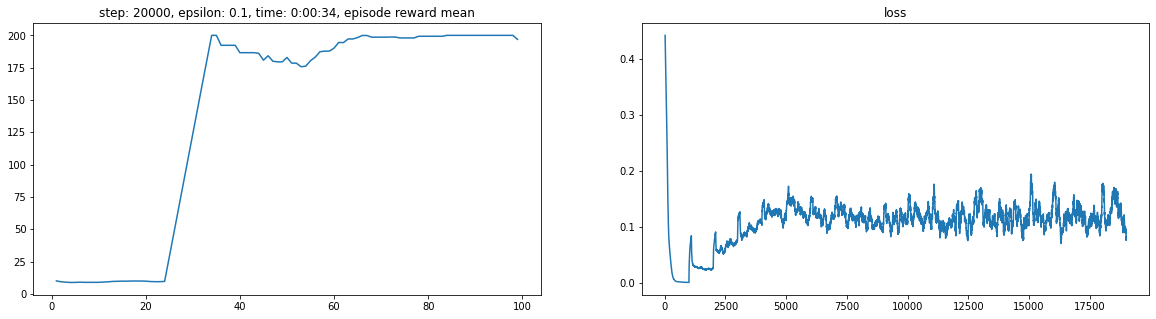

step: 21000, epsilon: 0.1, time: 0:00:36
episode reward mean: 200.0, epsisode reward max: 200.0, episode length mean: 200.0, episode length max: 200, loss: 0.12147481320425868
step: 22000, epsilon: 0.1, time: 0:00:38
episode reward mean: 200.0, epsisode reward max: 200.0, episode length mean: 200.0, episode length max: 200, loss: 0.13088549319654702
step: 23000, epsilon: 0.1, time: 0:00:40
episode reward mean: 200.0, epsisode reward max: 200.0, episode length mean: 200.0, episode length max: 200, loss: 0.19696098202839493
step: 24000, epsilon: 0.1, time: 0:00:42
episode reward mean: 200.0, epsisode reward max: 200.0, episode length mean: 200.0, episode length max: 200, loss: 0.08053019866347313
step: 25000, epsilon: 0.1, time: 0:00:44
episode reward mean: 200.0, epsisode reward max: 200.0, episode length mean: 200.0, episode length max: 200, loss: 0.18271078104153277
a new render begins
step: 25000, epsilon: 0.1, time: 0:00:44
episode reward mean: 197.8, epsisode reward max: 200.0, epi

In [11]:
name = 'CartPole-v0'
env_eval = gym.make(name)
env_eval.seed(seed)


config = Config()

start = timer()

dqn_agent = DQNAgent(env_name=name, network=DQNMLP, config=config)

obs = dqn_agent.env.reset()
for step in range(1, config.max_steps+1):
    epsilon = config.epsilon_by_step(step)
    
    action = dqn_agent.get_action(obs, epsilon)
    pre_obs = obs
    obs, reward, done, _ = dqn_agent.env.step(action)
    
    dqn_agent.memory.add((pre_obs, action, reward, obs, done))
    
    dqn_agent.train(step)
    
    if done:
        obs = dqn_agent.env.reset()
        
    if step % 1000 == 0:
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}, loss: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths,
            np.array(dqn_agent.losses[-10:]).mean()))
        
    if step % 10000 == 0:
        clear_output(True)
        
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(121)
        plt.title('step: {}, epsilon: {}, time: {}, episode reward mean'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        plt.plot(pd.Series(dqn_agent.rewards).rolling(10, 2).mean())
        plt.subplot(122)
        plt.title('loss')
        plt.plot(pd.Series(dqn_agent.losses).rolling(100, 20).mean())
        plt.show()
    
    if np.array(dqn_agent.rewards[-100:]).mean() > 195:  # 一开始会报一个warning: RuntimeWarning: Mean of empty slice， 可以忽略
        print('a new render begins')
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths))
                    
        break 
        
# dqn_agent.render(env_eval)

In [12]:
mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 100)
print(mean_returns)

199.69


### eps=0.1, lr=1e-4也会有训崩的时候，不过大多数情况下还是能训出来

In [14]:
torch.save(dqn_agent.model.state_dict(), 'dqn_cartpole.pt')

### learning rate 设成3e-4就会训崩掉，还是得设小点

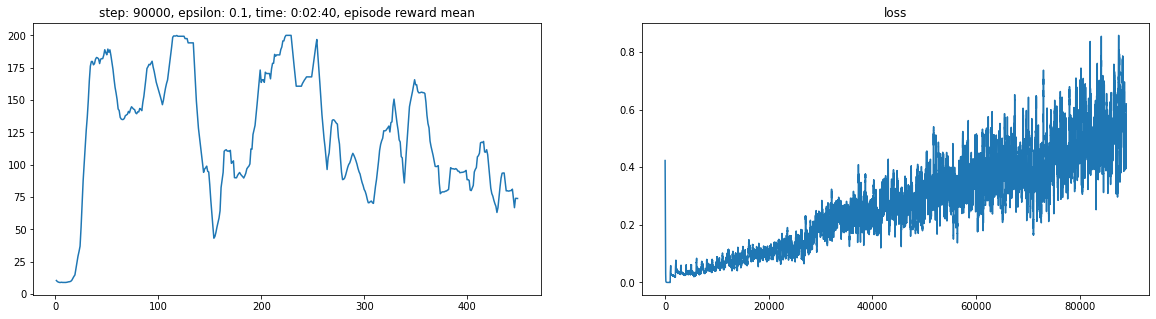

KeyboardInterrupt: 

In [22]:
name = 'CartPole-v0'
env_eval = gym.make(name)
env_eval.seed(seed)


config = Config()
config.lr = 3e-4

start = timer()

dqn_agent = DQNAgent(env_name=name, network=DQNMLP, config=config)


obs = dqn_agent.env.reset()
for step in range(1, config.max_steps+1):
    epsilon = config.epsilon_by_step(step)
    
    action = dqn_agent.get_action(obs, epsilon)
    pre_obs = obs
    obs, reward, done, _ = dqn_agent.env.step(action)
    
    dqn_agent.memory.add((pre_obs, action, reward, obs, done))
    
    dqn_agent.train(step)
    
    if done:
        obs = dqn_agent.env.reset()
        
    if step % 1000 == 0:
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}, loss: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths,
            np.array(dqn_agent.losses[-10:]).mean()))
        
    if step % 10000 == 0:
        clear_output(True)
        
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(121)
        plt.title('step: {}, epsilon: {}, time: {}, episode reward mean'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        plt.plot(pd.Series(dqn_agent.rewards).rolling(10, 2).mean())
        plt.subplot(122)
        plt.title('loss')
        plt.plot(pd.Series(dqn_agent.losses).rolling(100, 20).mean())
        plt.show()
    
    if np.array(dqn_agent.rewards[-100:]).mean() > 195:  # 一开始会报一个warning: RuntimeWarning: Mean of empty slice， 可以忽略
        print('a new render begins')
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths))
                    
        break 
        
# dqn_agent.render(env_eval)

In [ ]:
mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 100)
print(mean_returns)

In [34]:
dqn_agent.render(env_eval)

## MountainCar-v0

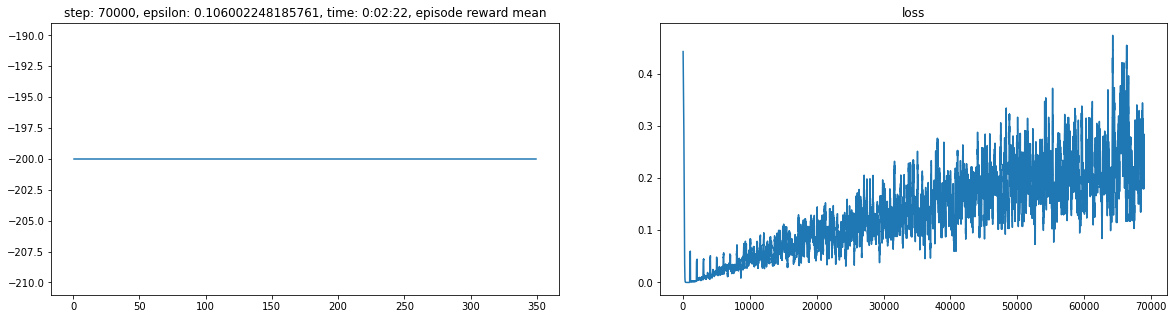

step: 71000, epsilon: 0.10285492012773749, time: 0:02:24
episode reward mean: -200.0, epsisode reward max: -200.0, episode length mean: 200.0, episode length max: 200, loss: 0.31308008488995254


KeyboardInterrupt: 

In [8]:
name = 'MountainCar-v0'
env_eval = gym.make(name)
env_eval.seed(seed)


config = Config()

start = timer()

dqn_agent = DQNAgent(env_name=name, network=DQNMLP, config=config)

obs = dqn_agent.env.reset()
for step in range(1, config.max_steps+1):
    epsilon = config.epsilon_by_step(step)
    
    action = dqn_agent.get_action(obs, epsilon)
    pre_obs = obs
    obs, reward, done, _ = dqn_agent.env.step(action)
    
    dqn_agent.memory.add((pre_obs, action, reward, obs, done))
    
    dqn_agent.train(step)
    
    if done:
        obs = dqn_agent.env.reset()
        
    if step % 1000 == 0:
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}, loss: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths,
            np.array(dqn_agent.losses[-10:]).mean()))
        
    if step % 10000 == 0:
        clear_output(True)
        
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(121)
        plt.title('step: {}, epsilon: {}, time: {}, episode reward mean'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        plt.plot(pd.Series(dqn_agent.rewards).rolling(10, 2).mean())
        plt.subplot(122)
        plt.title('loss')
        plt.plot(pd.Series(dqn_agent.losses).rolling(100, 20).mean())
        plt.show()
    
    if np.array(dqn_agent.rewards[-100:]).mean() > -110:  # 一开始会报一个warning: RuntimeWarning: Mean of empty slice， 可以忽略
        print('a new render begins')
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths))
                    
        break 
        
# dqn_agent.render(env_eval)

### 没训练出来，加了epsilon递减和梯度裁剪依然不行

## Acrobot-v1

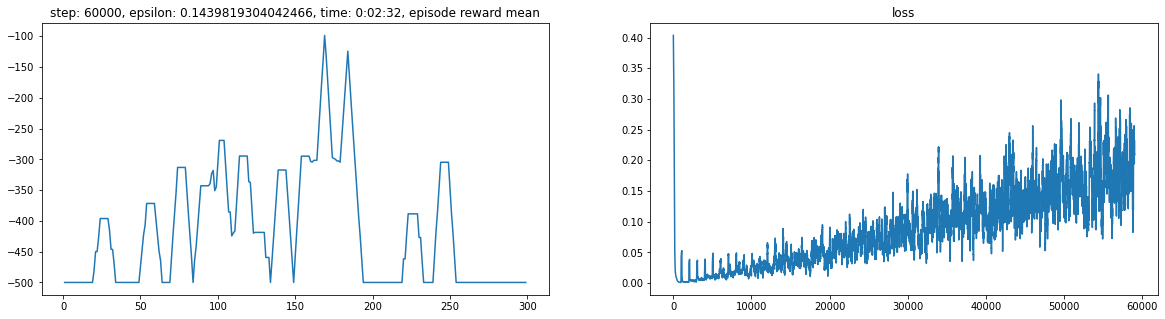

step: 61000, epsilon: 0.13958948026064688, time: 0:02:35
episode reward mean: -500.0, epsisode reward max: -500.0, episode length mean: 500.0, episode length max: 500, loss: 0.16423864662647247
step: 62000, epsilon: 0.13534103176119272, time: 0:02:38
episode reward mean: -500.0, epsisode reward max: -500.0, episode length mean: 500.0, episode length max: 500, loss: 0.16451033633202314


KeyboardInterrupt: 

In [15]:
name = 'Acrobot-v1'
env_eval = gym.make(name)
env_eval.seed(seed)


config = Config()

start = timer()

dqn_agent = DQNAgent(env_name=name, network=DQNMLP, config=config)

obs = dqn_agent.env.reset()
for step in range(1, config.max_steps+1):
    epsilon = config.epsilon_by_step(step)
    
    action = dqn_agent.get_action(obs, epsilon)
    pre_obs = obs
    obs, reward, done, _ = dqn_agent.env.step(action)
    
    dqn_agent.memory.add((pre_obs, action, reward, obs, done))
    
    dqn_agent.train(step)
    
    if done:
        obs = dqn_agent.env.reset()
        
    if step % 1000 == 0:
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}, loss: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths,
            np.array(dqn_agent.losses[-10:]).mean()))
        
    if step % 10000 == 0:
        clear_output(True)
        
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(121)
        plt.title('step: {}, epsilon: {}, time: {}, episode reward mean'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        plt.plot(pd.Series(dqn_agent.rewards).rolling(10, 2).mean())
        plt.subplot(122)
        plt.title('loss')
        plt.plot(pd.Series(dqn_agent.losses).rolling(100, 20).mean())
        plt.show()
    
    if np.array(dqn_agent.rewards[-100:]).mean() > -110:  # 一开始会报一个warning: RuntimeWarning: Mean of empty slice， 可以忽略
        print('a new render begins')
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths))
                    
        break 
        
# dqn_agent.render(env_eval)

### 也没训出来。。。

## LunarLander-v2

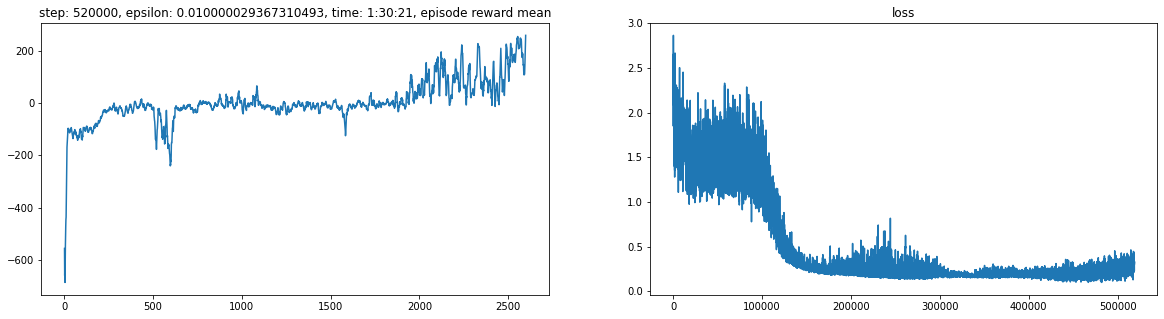

step: 521000, epsilon: 0.010000028404535538, time: 1:30:29
episode reward mean: 124.20494866653999, epsisode reward max: 305.4221582612945, episode length mean: 698.0, episode length max: 1000, loss: 0.17035019919276237
step: 522000, epsilon: 0.010000027473324099, time: 1:30:32
episode reward mean: 258.0723120303708, epsisode reward max: 275.5493870395131, episode length mean: 294.0, episode length max: 360, loss: 0.3178092435002327
step: 523000, epsilon: 0.010000026572641402, time: 1:30:37
episode reward mean: 186.8815950630338, epsisode reward max: 296.3710521059228, episode length mean: 404.6, episode length max: 1000, loss: 0.12680681571364402
step: 524000, epsilon: 0.010000025701486595, time: 1:30:41
episode reward mean: 245.0824238486892, epsisode reward max: 294.14285019742897, episode length mean: 406.0, episode length max: 547, loss: 0.10951890870928764
step: 525000, epsilon: 0.010000024858891642, time: 1:30:44
episode reward mean: 281.5980640303355, epsisode reward max: 310.0

In [16]:
name = 'LunarLander-v2'
env_eval = gym.make(name)
env_eval.seed(seed)


config = Config()

start = timer()

dqn_agent = DQNAgent(env_name=name, network=DQNMLP, config=config)

obs = dqn_agent.env.reset()
for step in range(1, config.max_steps+1):
    epsilon = config.epsilon_by_step(step)
    
    action = dqn_agent.get_action(obs, epsilon)
    pre_obs = obs
    obs, reward, done, _ = dqn_agent.env.step(action)
    
    dqn_agent.memory.add((pre_obs, action, reward, obs, done))
    
    dqn_agent.train(step)
    
    if done:
        obs = dqn_agent.env.reset()
        
    if step % 1000 == 0:
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}, loss: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths,
            np.array(dqn_agent.losses[-10:]).mean()))
        
    if step % 10000 == 0:
        clear_output(True)
        
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(121)
        plt.title('step: {}, epsilon: {}, time: {}, episode reward mean'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        plt.plot(pd.Series(dqn_agent.rewards).rolling(10, 2).mean())
        plt.subplot(122)
        plt.title('loss')
        plt.plot(pd.Series(dqn_agent.losses).rolling(100, 20).mean())
        plt.show()
    
    if np.array(dqn_agent.rewards[-100:]).mean() > 200:  # 一开始会报一个warning: RuntimeWarning: Mean of empty slice， 可以忽略
        print('a new render begins')
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths))
                    
        break 
        
# dqn_agent.render(env_eval)

In [17]:
mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 100)
print(mean_returns)

229.35621392955522


### 没有使用epsilon递减（eps=0.1）以及不用梯度裁剪，训练还收敛得更快

可能是梯度裁剪的值设置得不恰当

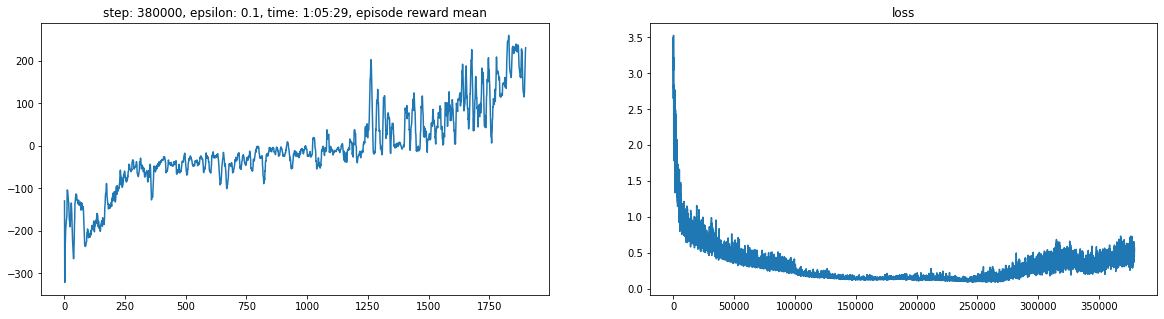

step: 381000, epsilon: 0.1, time: 1:05:34
episode reward mean: 264.7875815418921, epsisode reward max: 291.9949734938981, episode length mean: 337.2, episode length max: 366, loss: 0.3810767881572247
a new render begins
step: 381000, epsilon: 0.1, time: 1:05:37
episode reward mean: 221.7195431746794, epsisode reward max: 269.35766434703515, episode length mean: 480.4, episode length max: 789


In [7]:
name = 'LunarLander-v2'
env_eval = gym.make(name)
env_eval.seed(seed)


config = Config()

start = timer()

dqn_agent = DQNAgent(env_name=name, network=DQNMLP, config=config)

obs = dqn_agent.env.reset()
for step in range(1, config.max_steps+1):
    epsilon = config.epsilon_by_step(step)
    
    action = dqn_agent.get_action(obs, epsilon)
    pre_obs = obs
    obs, reward, done, _ = dqn_agent.env.step(action)
    
    dqn_agent.memory.add((pre_obs, action, reward, obs, done))
    
    dqn_agent.train(step)
    
    if done:
        obs = dqn_agent.env.reset()
        
    if step % 1000 == 0:
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}, loss: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths,
            np.array(dqn_agent.losses[-10:]).mean()))
        
    if step % 10000 == 0:
        clear_output(True)
        
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(121)
        plt.title('step: {}, epsilon: {}, time: {}, episode reward mean'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        plt.plot(pd.Series(dqn_agent.rewards).rolling(10, 2).mean())
        plt.subplot(122)
        plt.title('loss')
        plt.plot(pd.Series(dqn_agent.losses).rolling(100, 20).mean())
        plt.show()
    
    if np.array(dqn_agent.rewards[-100:]).mean() > 200:  # 一开始会报一个warning: RuntimeWarning: Mean of empty slice， 可以忽略
        print('a new render begins')
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths))
                    
        break 
        
# dqn_agent.render(env_eval)

In [8]:
mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 100)
print(mean_returns)

251.6408838610296


In [9]:
torch.save(dqn_agent.model.state_dict(), 'dqn_lunarlander.pt')

In [7]:
name = 'LunarLander-v2'
env_eval = gym.make(name)
env_eval.seed(seed)

config = Config()
dqn_agent = DQNAgent(env_name=name, network=DQNMLP, config=config)
dqn_agent.model.load_state_dict(torch.load('dqn_lunarlander.pt'))

<All keys matched successfully>

In [8]:
mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 100)
print(mean_returns)

253.9201954760637
